## Visualizing the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

### Imports

In [ ]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd

from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

import seaborn as sns

### Loading a pre-trained model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Extract and visualize the filters 

In [ ]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    # TO COMPLETE
    # return filters
    x=torch.tensor(model.features[layer_idx].weight,requires_grad=False)

    return x

In [ ]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


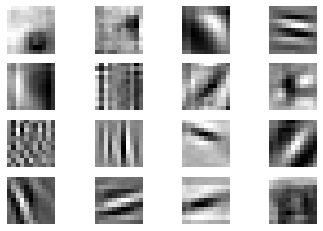

In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()

### 

## Extract and visualize feature maps 

In this section, we will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

In [ ]:

im=Image.open('man_bike.JPEG').convert("RGB")

In [ ]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)

In [ ]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """

    model_weights=[]
    conv_layers=[]
    all_layers=[]
    counter = 0 
    maxpool=[]
    model_children = list(model.children())
    # append all the conv layers and their respective weights to the list

    for j in range(len(model_children[0])):
        child= model_children[0][j]
        all_layers.append(child)
        if type(child) == nn.MaxPool2d:
            
            counter += 1
            #model_weights.append(child.weight)
            conv_layers.append(child)


    
    results = [all_layers[0](image)]
  
    for i in range(1, len(all_layers)):
        # pass the result from the last layer to the next layer
        x=all_layers[i](results[-1])
        results.append(x)
        if len(results[i][0][0]) == len(results[i-1][0][0])// 2:
          maxpool.append(x)
       
    # make a copy of the `results`
    maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]
    
    return maxpool

In [ ]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Displaying the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

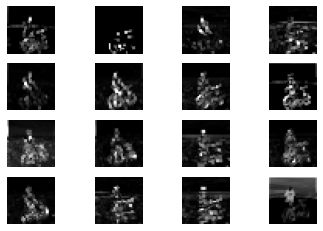

In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[0][0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()

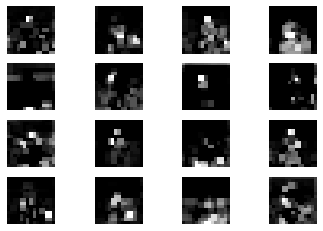

In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[1][0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()

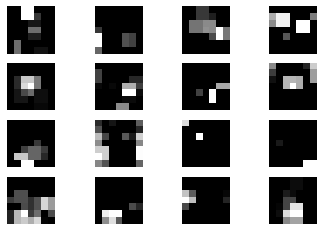

In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[2][0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()

## Gradient-weighted Class Activation Mapping (Grad-CAM) 

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

In [ ]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = alexnet(pretrained=True)

In [ ]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

In [ ]:
pred_cls

tensor([[444]])

## Generate Grad-CAM heatmaps

In [ ]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[:,-1].backward()
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image).detach() 
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
      activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap

In [ ]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

## Display heatmaps 
Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [ ]:
def display_heatmap(heatmap,image):
#1
  (w, h) = (image.shape[0], image.shape[1])
  heatmap = cv2.resize(heatmap.numpy(), (w, h))
  
#2
  
  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + 1e-8
  heatmap_normalized = numer / denom
  heatmap_normalized = (heatmap_normalized * 255).astype("uint8")

  
#3

  heatmap_normalized = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    
#4
  heatmap_normalized=heatmap_normalized * 0.4
#5
  #heatmap_normalized=heatmap_normalized.reshape((256,256,1))*np.ones([256,256,3])
  weighted_image= cv2.addWeighted(heatmap_normalized, 0.7, image, 0.3, 0)
#6
  numer = weighted_image - np.min(weighted_image)
  denom = (weighted_image.max() - weighted_image.min()) + 1e-8
  final_image = numer / denom
  final_image = (final_image * 255).astype("uint8")

  return final_image

In [ ]:
image = cv2.imread('man_bike.JPEG')
image=cv2.resize(image,(256,256))
image = np.asarray(image, np.float64)


In [ ]:
display=display_heatmap(heatmap,image)

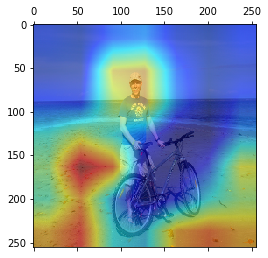

In [ ]:
plt.matshow(display[:, :, ::-1])